# <center>CITS5017 Project 1<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [48]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Load Image Dataset

In [49]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

def resize_images(images, size=(96, 96)):
    images_resized = np.array([tf.image.resize(image, size).numpy() for image in images])
    return images_resized

# Call load_data to build the training and validation sets
X_train, y_train, class_names = load_data("train.pkl")
X_val, y_val, _ = load_data("val.pkl")

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Check shape of data : Image size = (64, 64, 3)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Resize images for MobileNetV2 model : Image size = (96, 96, 3)
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)

# Check shape after resizing
print(f"Resized Training data shape: {X_train_resized.shape}")
print(f"Resized Validation data shape: {X_val_resized.shape}")

Training data shape: (2000, 64, 64, 3)
Validation data shape: (500, 64, 64, 3)
Resized Training data shape: (2000, 96, 96, 3)
Resized Validation data shape: (500, 96, 96, 3)


# Tasks
## (i) Display 20 sample images from training set and validation set

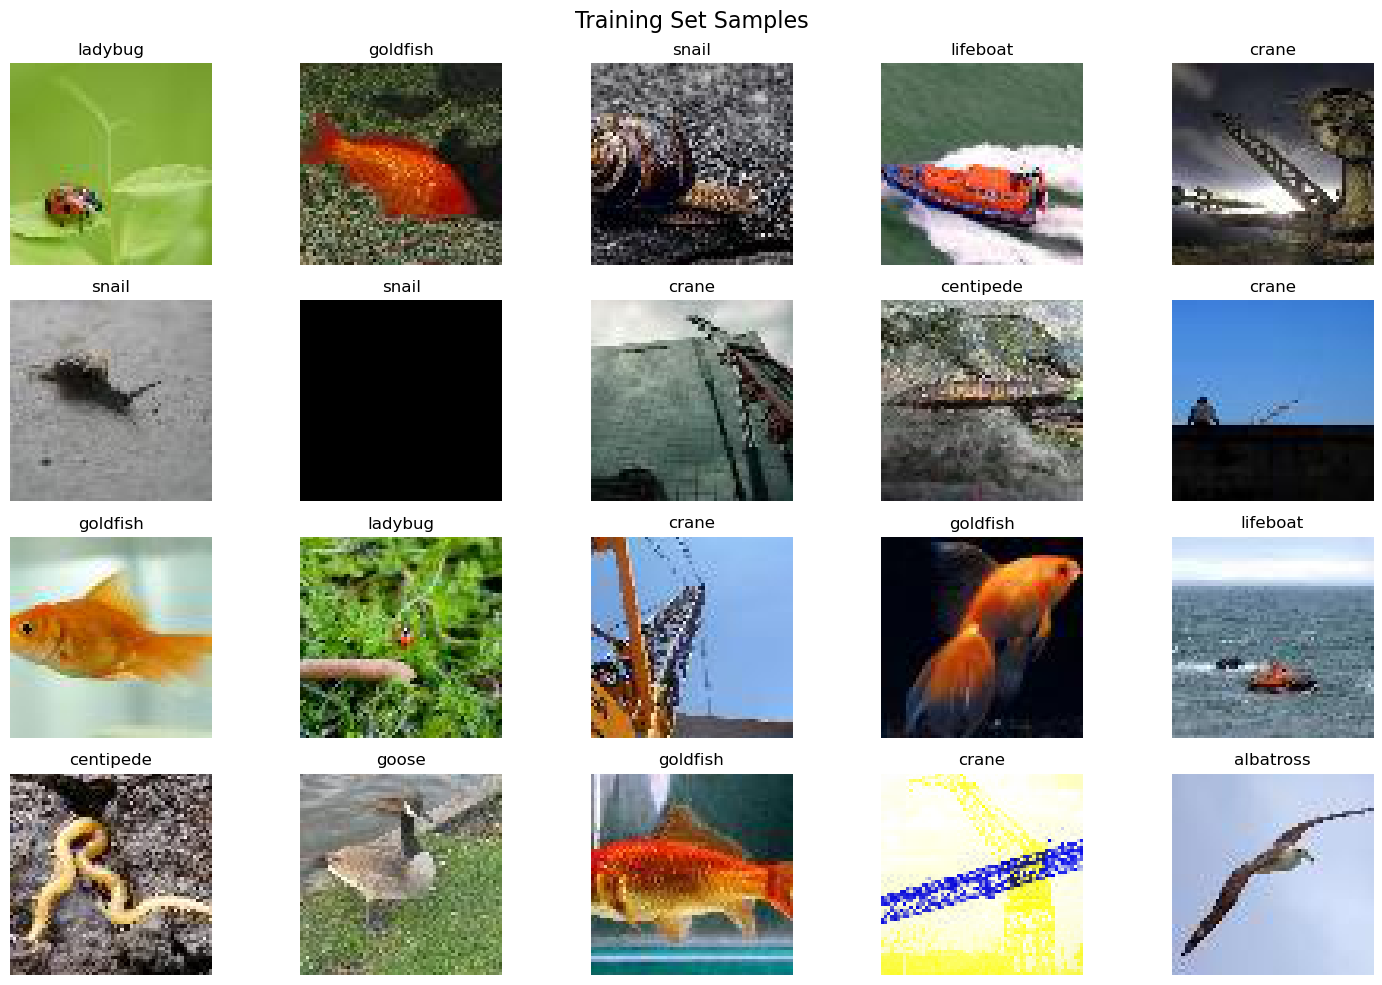

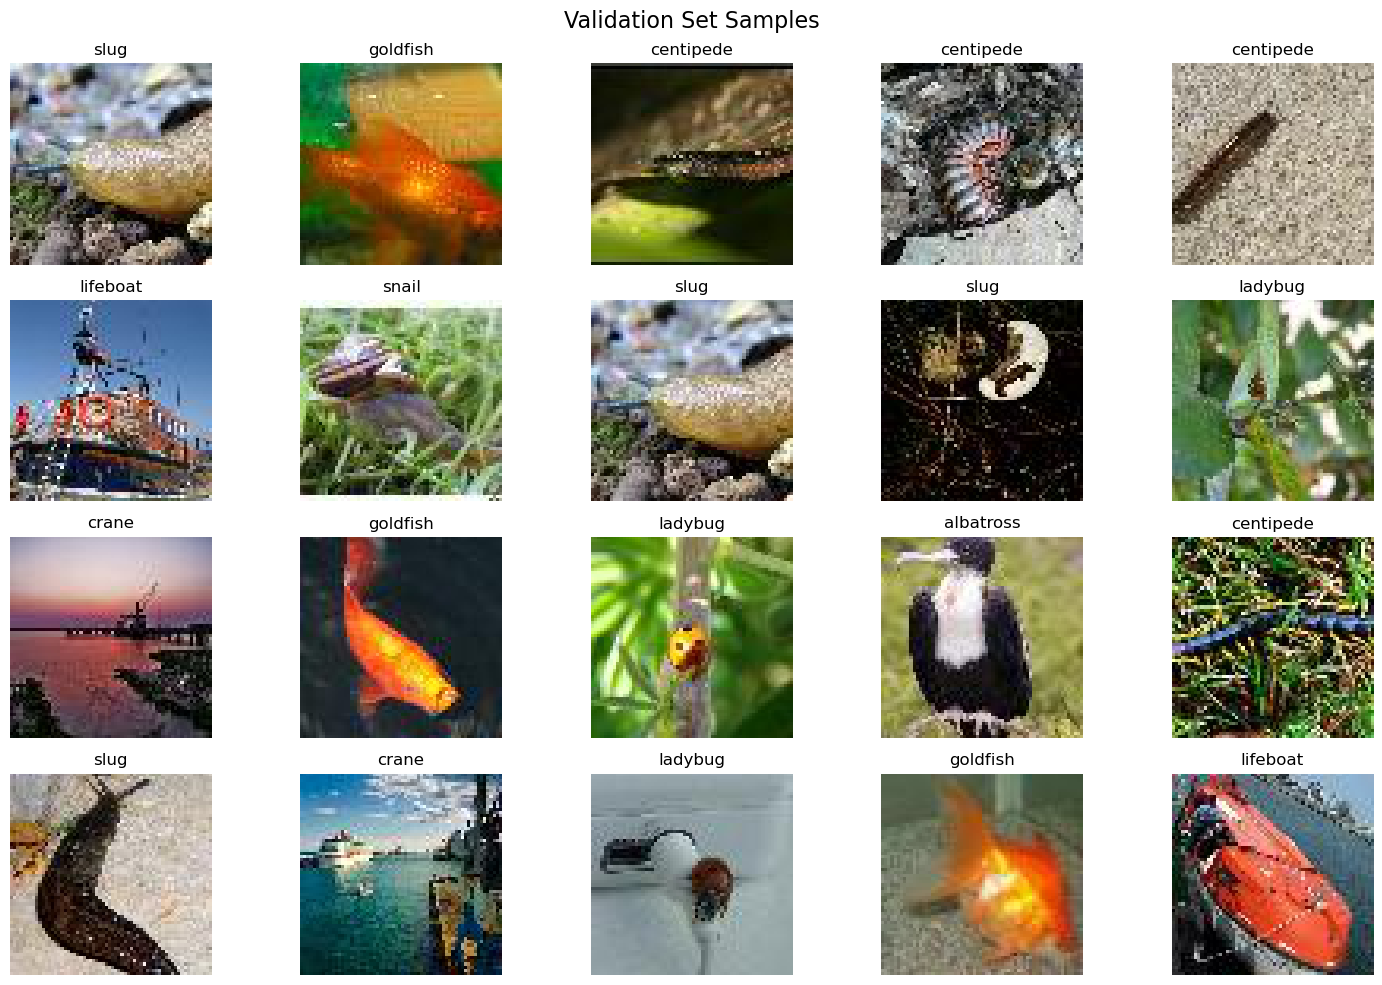

In [50]:
# Function to display 20 sample images from the dataset
def displayImages(images, labels, class_names, title):
    num_samples = 20
    indices = np.random.choice(images.shape[0], num_samples)
    sampled_images = images[indices]
    sampled_labels = labels[indices]
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    
    for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(class_names[label])
        ax.axis("off")
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

displayImages(X_train, y_train, class_names, "Training Set Samples")
displayImages(X_val, y_val, class_names, "Validation Set Samples")

## (ii) Implementation of CNN Model
### Design of CNN architecture

In [22]:
# Function to create a CNN model
def create_cnn(kernel_size, num_kernels, dropout_rate):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(num_kernels, kernel_size=kernel_size, activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Convolutional Layer 2
    model.add(Conv2D(num_kernels*2, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Convolutional Layer 3
    model.add(Conv2D(num_kernels*4, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(len(class_names), activation='softmax'))
    
    return model

# Set hyperparameters
kernel_size = (3, 3)
num_kernels = 32
dropout_rate = 0.5

model = create_cnn(kernel_size, num_kernels, dropout_rate)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,002 (2.64 MB)

 Trainable params: 692,554 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

### Manual Hyperparameter Tuning
- hyperparameter tuning code
- hyperparameter values experimented
- optimal hyperparameter values

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

def train_cnn(model, X_train, y_train, X_val, y_val, batch_size, epochs):    
    # Compile model
    s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
    # piecewise_constant_fn = piecewise_constant_fn(epoch=20)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    # lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
    # lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[lr_scheduler])
    
    # Evaluate model
    val_loss, val_acc = model.evaluate(X_val, y_val)

    return history


In [23]:
# Hyperparameter values to explore
kernel_sizes = [(3, 3), (5, 5)]
num_kernels_list = [32, 64]
dropout_rates = [0.3, 0.5]

for kernel_size in kernel_sizes:
    for num_kernels in num_kernels_list:
        for dropout_rate in dropout_rates:
            print(f"Testing kernel_size={kernel_size}, num_kernels={num_kernels}, dropout_rate={dropout_rate}")
            
            model = create_cnn(kernel_size, num_kernels, dropout_rate)
            
            s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
            learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
            optimizer = tf.keras.optimizers.SGD(learning_rate)
            
            # Compile model
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
            # Train model
            history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                                validation_data=(X_val, y_val))
            
            # Evaluate model
            val_loss, val_acc = model.evaluate(X_val, y_val)
            print(f"Validation accuracy: {val_acc}, Validation loss: {val_loss}")

Testing kernel_size=(3, 3), num_kernels=32, dropout_rate=0.3
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1557 - loss: 2.6161 - val_accuracy: 0.1800 - val_loss: 2.3467
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3002 - loss: 2.0034 - val_accuracy: 0.2860 - val_loss: 2.0388
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3805 - loss: 1.7871 - val_accuracy: 0.3580 - val_loss: 1.8542
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4275 - loss: 1.6497 - val_accuracy: 0.3880 - val_loss: 1.7930
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4884 - loss: 1.4871 - val_accuracy: 0.4400 - val_loss: 1.6833
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4895 - loss: 1.4756 - val_accuracy: 0.4560 - val_loss: 1.6445
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5426 - loss: 1.3239 - val_accuracy: 0.4260 - val_loss: 1.6636
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

## (iii) Test CNN Model Implementation

c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,561,290 (5.96 MB)

 Trainable params: 1,560,394 (5.95 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.1463 - loss: 4.7197 - val_accuracy: 0.1680 - val_loss: 4.5820
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.1815 - loss: 3.4669 - val_accuracy: 0.1600 - val_loss: 2.4113
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.1857 - loss: 2.8241 - val_accuracy: 0.1920 - val_loss: 2.1122
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.2118 - loss: 2.4672 - val_accuracy: 0.2500 - val_loss: 2.1091
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.2306 - loss: 2.2899 - val_accuracy: 0.2900 - val_loss: 2.0846
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.2310 - loss: 2.2083 - val_accuracy: 0.3560 - val_loss: 1.9445
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.2920 - loss: 2.0936 - val_accuracy: 0.3440 - val_loss: 1.9124
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.2941 - loss: 1.9910 - val_accuracy: 0.

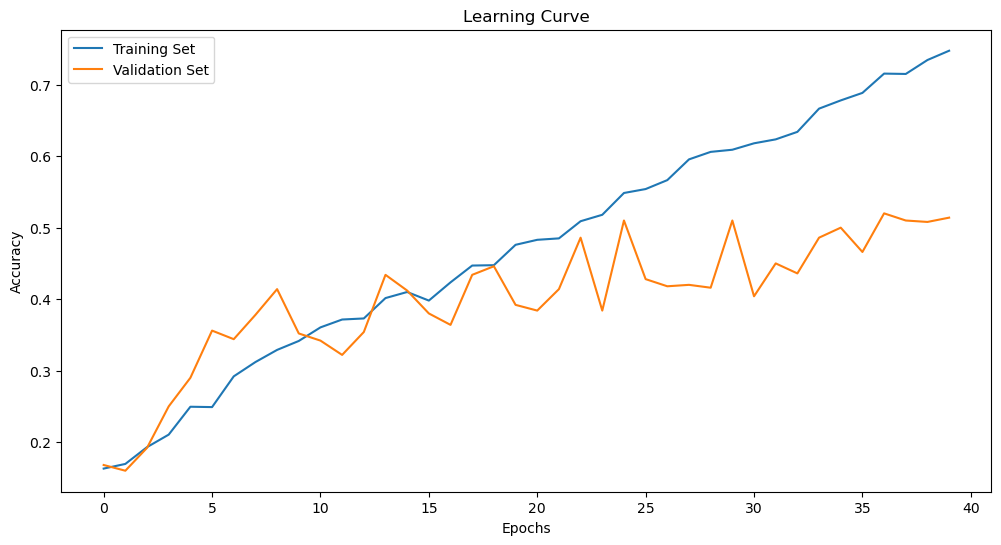

In [39]:
# Function to plot learning curves on same figure
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot accuracy graph
    axs[0].plot(history.history['accuracy'], label='Training Set')
    axs[0].plot(history.history['val_accuracy'], label='Validation Set')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    # Plot loss graph
    axs[1].plot(history.history['loss'], label='Training Set')
    axs[1].plot(history.history['val_loss'], label='Validation Set')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    fig.suptitle('Learning Curves', fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Training CNN Model
cnn_model_file = 'Lau_Allison-CNN.keras'

if os.path.exists(cnn_model_file):
    # Load the model
    cnn_model = tf.keras.models.load_model(cnn_model_file)
    print(f"Load '{cnn_model_file}' model successfully")
    
    # Display model architecture
    cnn_model.summary()
    
    # Compile the model with a tiny learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model for 1 more epoch
    cnn_history = cnn_model.fit(X_train, y_train, epochs=1, batch_size=32,
                                validation_data=(X_val, y_val))
    
else:
    # Optimal hyperparameters
    kernel_size = (3, 3)
    num_kernels = 64
    dropout_rate = 0.5
    
    # Create and compile the model
    cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Display model architecture
    cnn_model.summary()
    
    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    # Train the model from scratch
    cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])
    
    # Save the model
    cnn_model.save(cnn_model_file)
    print(f"Save '{cnn_model_file}' model successfully")

    # Plot learning curves
    plot_learning_curves(cnn_history)

### Evaluation of CNN Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Accuracy: 0.7520


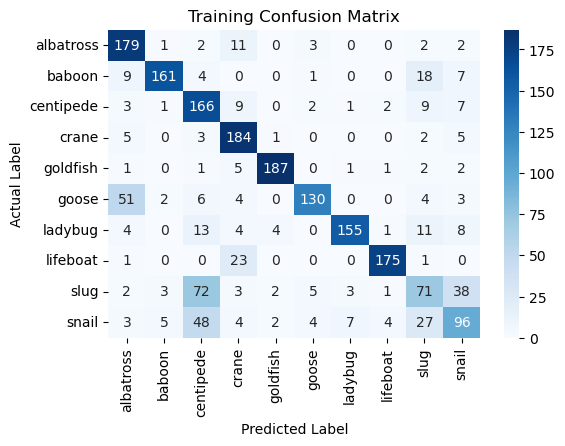

Validation Accuracy: 0.5100


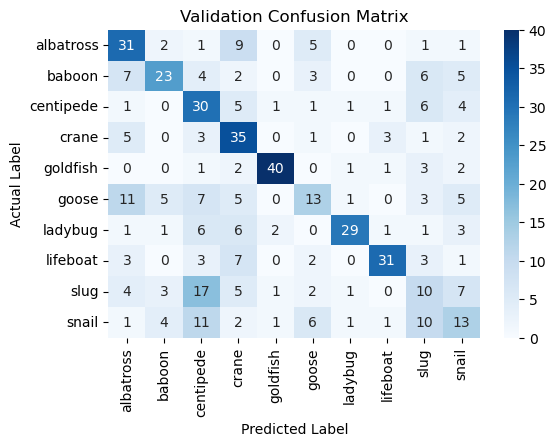

In [40]:
# Function to display confusion matrix
def display_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Perform predictions on training and validation sets
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    
    # Compute prediction accuracy and confusion matrix
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Print
    print(f"Training Accuracy: {train_accuracy:.4f}")
    display_confusion_matrix(train_cm, "Training Confusion Matrix")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    display_confusion_matrix(val_cm, "Validation Confusion Matrix")

# Evaluate CNN model
evaluate_model(cnn_model, X_train, y_train, X_val, y_val)

## (iv) Transfer Learning using MobileNetV2

In [25]:
# Function to create MobileNetV2 model
def create_mobilenetv2(input_shape=(96, 96, 3), num_classes=10):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                                   weights='imagenet', 
                                                   input_shape=input_shape, 
                                                   pooling='avg')
    
    # Freeze the base model
    base_model.trainable = False
    
    # Adapt model to our Image dataset (10 classes)
    # model = tf.keras.models.Sequential([
    #     base_model,
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(num_classes, activation='softmax')
    # ])
    
    return model

# Create the model
model = create_mobilenetv2()

# Display model architecture
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 26, 26, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 9, 9, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,564,363 (5.97 MB)

 Trainable params: 1,563,466 (5.96 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1 (8.00 B)

In [36]:
# Training MobileNetV2 model
mnv2_model_file = 'Lau_Allison-MobileNetV2.keras'

# Create and compile the model
mnv2_model = create_mobilenetv2()
mnv2_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train the model
mnv2_history = mnv2_model.fit(X_train_resized, y_train, epochs=20, batch_size=32,
                         validation_data=(X_val_resized, y_val))

# Save the model
mnv2_model.save(mnv2_model_file)
print(f"Save '{mnv2_model_file}' model successfully")
    
# Plot learning curves
plot_learning_curves(mnv2_history)

In [ ]:
# Evaluate MobileNetV2 model
evaluate_model(mnv2_model, X_train_resized, y_train, X_val_resized, y_val)

## (v) Comparisons